# TME8: Détection d'exceptions

- LE LORIER Yann
- NGUYEN Hoang-Son

In [549]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.inspection import DecisionBoundaryDisplay

## Génération de données

Nous allons tout d'abord créer une base de données artificielle, en nous basant sur les données vues en cours.

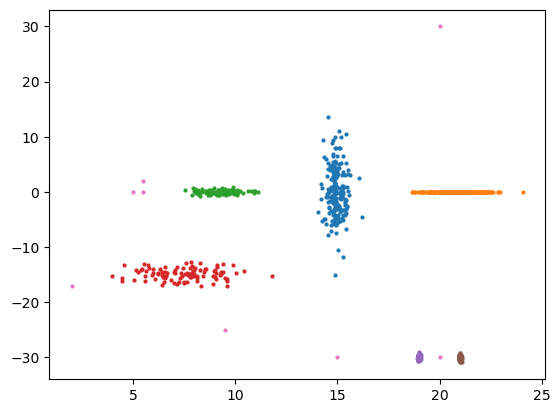

In [542]:
mus = [[15., 0.], [21., 0.], [9.3, 0.], [7.5, -15.], [19, -30.], [21, -30.]]
sigs = [[0.1, 20], [1, 0.001], [0.6, 0.1], [2, 1.], [0.001, 0.1], [0.001, 0.1]]
Ns = [200, 200, 100, 100, 100, 100]

exception_pts = [[20., 30.], [5.5, 0], [5.5, 2.], [5., 0], [2., -17.], [9.5, -25.], [15,-30.], [20, -30.]]
pts = []
pts_data = []
for i in range(len(Ns)):
    sampler = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.tensor(mus[i]), covariance_matrix=torch.diag(torch.tensor(sigs[i])))
    pts_generated = [sampler.sample().tolist() for _ in range(Ns[i])]
    # visualiser
    pts.append(np.asarray(pts_generated))
    # train
    pts_data = pts_data + pts_generated
pts.append(np.asarray(exception_pts))
pts_data += exception_pts
pts_data = np.asarray(pts_data)
for p in pts:
    plt.scatter(p[:, 0], p[:, 1], s=4)

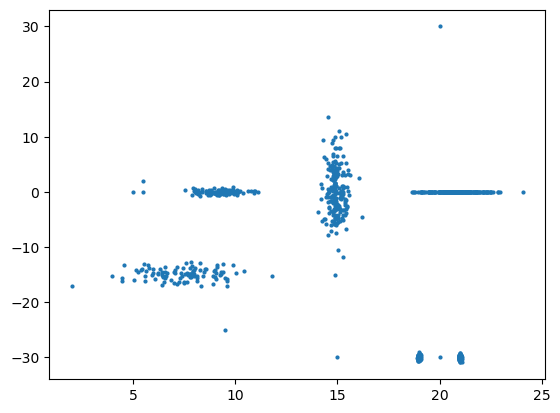

In [543]:
plt.scatter(pts_data[:,0], pts_data[:,1], s=4)

### One Class SVM

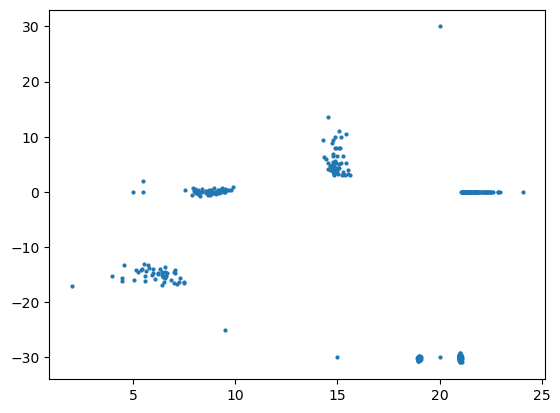

In [602]:
clf_svm = OneClassSVM(kernel='rbf')
clf_svm.fit(pts_data)
pred = clf_svm.predict(pts_data)
idx = np.where(pred==-1)
pts_exception = pts_data[idx]
# visualisation
plt.scatter(pts_exception[:,0], pts_exception[:,1], s=4)

### Local Outlier Factor

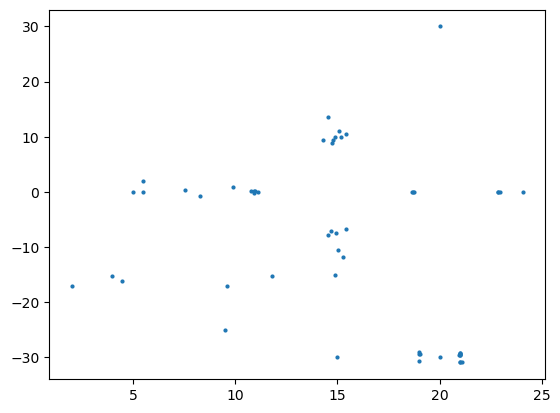

In [580]:
clf_lof = LocalOutlierFactor()
pred = clf_lof.fit_predict(pts_data)
idx = np.where(pred==-1)
pts_exception = pts_data[idx]
# visualisation
plt.scatter(pts_exception[:,0], pts_exception[:,1], s=4)

### Isolation Forest

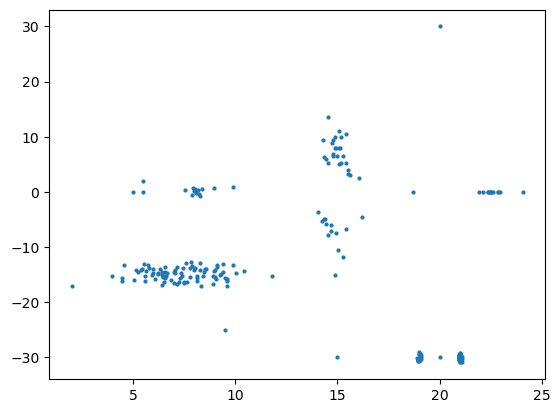

In [582]:
clf_isolation = IsolationForest(random_state=0).fit(pts_data)
pred = clf_isolation.predict(pts_data)
idx = np.where(pred==-1)
pts_exception = pts_data[idx]
# visualisation
plt.scatter(pts_exception[:,0], pts_exception[:,1], s=4)

### Observations

Nous constatons une différence entre les méthodes, par rapport à la sévérité de classification comme des exceptions. Dans le cas des forêts d'isolation, nous constatons un plus grand nombre d'exemples classés comme des exceptions.

De plus, pour les One Class SVMs, si nous avons une distributions des donnés qui est assez complexe, comme le cas étudié, le classifieur d'exception est insuffisant pour révéler une frontière de décision acceptable, et laisse un groupe considérable du jeu de données comme étant une exception.

## Explication naïves

### Approche de contrefactuels pour forêts d'isolation

Pour les forêts d'isolation, les traiter comme un classifieur traditionnel avec une approche contrefactuelle pour les expliquer est équivalent à expliquer un classifieur binaire auquel on a accès. Une approche contrefactuelle pour un exemple classé comme une exception donne les changements en attributs pour pouvoir être classifié comme un exemple qui n'est pas exceptionnel, selon la méthode utilisée (Growing Spheres par exemple).

### Explications par vecteur d'importance

Les approches par vecteur d'importance d'attributs donne un degré d'importance à chacun des attributs des exemples, des approches comme LIME peuvent extraire des attributs qui ont un poids plus significatif pour éloigner l'exemple du jeu de données classique.

## Explications moins naïves

Nous allons réutiliser notre code du TME 1 pour appliquer une approche contrefactuelle à la détection d'exceptions. Plus concrètement, nous allons utiliser l'algorithme Growing Spheres pour expliquer un exemple, qui pourrait être une exception. Nous avons adapté le code pour le cas d'utilisation spécifique.

In [616]:
def generate_SL(x, ray1, ray2, n):
  d = x.shape[0]
  z = np.random.multivariate_normal(np.zeros(d),np.diag(np.ones(d)),n)
  z = (z/(np.linalg.norm(z, axis=1)).reshape((-1,1)))
  u = np.random.uniform(ray1**d, ray2**d, n)
  u = u**(1/d)
  u = u.reshape((-1,1))
  x_new = x+z*u
  return x_new

def GSG(clf, x, etha, n):
  """
    Params:
      clf : le classifieur
      x   : la données à expliquer
      etha: hyperparametre, le rayon de recherche de l'algo
      n   : hyperparametre, le nombre de données générées à chaque itération de l'algo
  """
  f_x = clf.predict([x])[0]
  z = generate_SL(x,0,etha,n)

  while (clf.predict(z)==f_x).sum()!=n:
    etha /=2
    z = generate_SL(x,0,etha,n)

  a0 = etha
  a1 = 2*etha

  while (clf.predict(z)==f_x).sum()==n:
    z = generate_SL(x,a0,a1,n)
    a0 = a1
    a1 += etha
  z = z[clf.predict(z)!=f_x]
  idx_min = np.argmin(np.linalg.norm(x-z, axis=1))
  return z[idx_min]

def GSFS(clf, x, etha, n):
  """
    Params:
      clf : le classifieur
      x   : la données à expliquer
      etha: hyperparametre, le rayon de recherche de l'algo
      n   : hyperparametre, le nombre de données générées à chaque itération de l'algo
  """
  f_x = clf.predict([x])
  e = GSG(clf, x, etha, n)
  e_tmp = np.copy(e)
  e_target = None
  while clf.predict([e_tmp]) != f_x:
    e_target = np.copy(e_tmp) #deep copy ici
    features_idx = np.where(e_tmp!=x)[0]
    i = features_idx[np.argmin(np.abs(e_tmp[features_idx]-x[features_idx]))]
    e_tmp[i] = x[i]
  return e, e_target

In [598]:
def visualisation_2D(data, y, clf, x, GS, etha=5, n=50) -> None:
  """
    Params:
      data: données
      y   : labels des données
      clf : un classfifier
      x   : un point de départ dont point cicle nous voulons chercher
      GS  : une fonction qui genère le point cible selon Algorithme Growing Spheres
      etha: hyperparamètre, rayon de recherche
      n   : hyperparamètre, nombre de données générés à chaque itération
  """
  pred_this = None
  if clf.__class__.__name__ == 'LocalOutlierFactor':
    pred_this = 'fit_predict'
  else:
    pred_this = 'predict'
  disp = DecisionBoundaryDisplay.from_estimator(
      clf, data, response_method=pred_this,
      xlabel="X", ylabel="Y",
      alpha=0.5)

  disp.ax_.scatter(data[:, 0], data[:, 1], c=y, edgecolor="k",alpha=0.2)
  disp.ax_.scatter(x[0], x[1], color="red", label="point choisi")

  if GS.__name__ == "GSG":
    e = GS(clf, x, etha, n)
    disp.ax_.scatter(e[0], e[1], color=np.random.rand(1,3), label="cible_"+GS.__name__)
    plt.title("Growing Spheres Generation")
  else:
    e, e_modif = GS(clf, x, etha, n)
    disp.ax_.scatter(e[0], e[1], color=np.random.rand(1,3), label="cible_GSG")
    disp.ax_.scatter(e_modif[0], e_modif[1], color=np.random.rand(1,3), label="cible_GSFS")
    plt.title("Growing Spheres Feature Selection")
  plt.legend()
  plt.show()

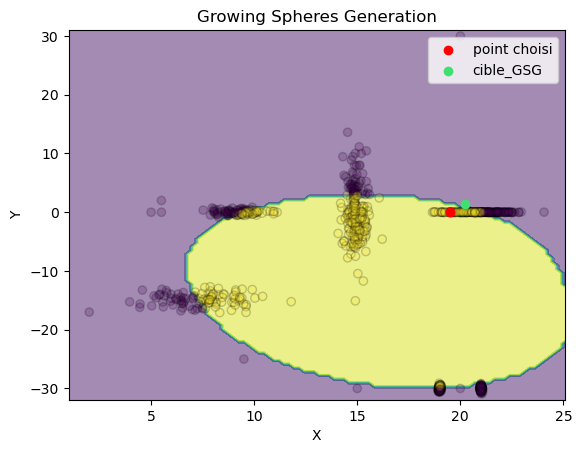

In [617]:
x = pts_data[np.random.randint(len(pts_data))]
GS = GSG
visualisation_2D(pts_data, clf_svm.predict(pts_data), clf_svm, x, GS)

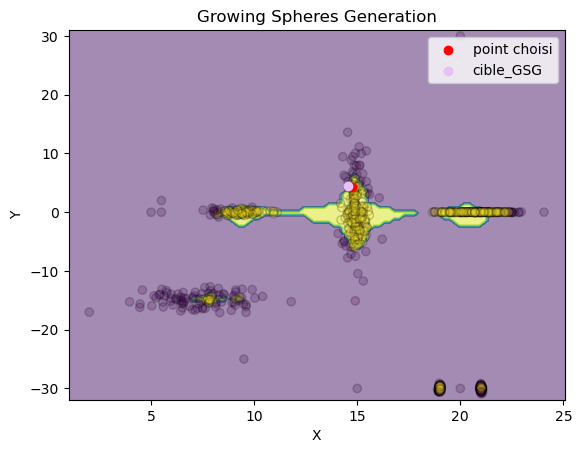

In [621]:
x = pts_data[np.random.randint(len(pts_data))]
GS = GSG
visualisation_2D(pts_data, clf_isolation.predict(pts_data), clf_isolation, x, GS)

### Observations

En effet, l'algorithme de Growing Spheres montre une limitation qui est facile à identifier, même à l'œil nu, montrant une frontière de décision qui n'est pas assez descriptive pour le jeu de données en main. Ceci pourrait indiquer une mauvaise paramétrisation de l'algorithme, comme par exemple le rayon de recherche.

La détection d'exceptions fait penser néanmoins à la capacité de généralisation du modèle. Si un exemple est considéré comme une exception, cela peut être dû à un entraînement insuffisant du modèle, ne l'exposant pas à assez de données, ce qui mène à considérer l'efficacité de l'entraînement.